# Calculate Nino 3.4 index

In [28]:
%load_ext autoreload
%autoreload 2

import xarray as xr
import numpy as np
import numpy.ma as ma
import matplotlib as plt
import matplotlib.pyplot as plt
import os
import cftime
import nc_time_axis
import numpy.matlib
from season_util import season_mean
from wgt_areaave import wgt_areaave as wa

from nino34 import nino34

# # for reloading libraries
# import importlib
# importlib.reload(jlat)
# importlib.reload(nc_time_axis)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


### Nino 3.4 definition

Niño 3.4 (5N-5S, 170W-120W):  The  Niño 3.4 anomalies may be thought of as representing the average equatorial SSTs across the Pacific from about the dateline to the South American coast.  The Niño 3.4 index typically uses a 5-month running mean, and El Niño or La  Niña events are defined when the  Niño 3.4 SSTs exceed +/- 0.4C for a period of six months or more.

https://climatedataguide.ucar.edu/climate-data/nino-sst-indices-nino-12-3-34-4-oni-and-tni

<img src="https://climatedataguide.ucar.edu/sites/default/files/users/dschneid/key_figures_428.png">

### Set coordinates

In [29]:
minlat = -5
maxlat = 5
minlon = -170
maxlon = -120

#### Adjust longitudes if necessary

In [30]:
if minlon < 0:
    minlon = minlon + 360
if maxlon < 0:
    maxlon = maxlon + 360

### Load data

In [31]:
pathin = '/glade/collections/cmip/CMIP6/CMIP/NCAR/CESM2/1pctCO2/r1i1p1f1/Amon/ts/gn/latest'
filein = 'ts_Amon_CESM2_1pctCO2_r1i1p1f1_gn_000101-005012.nc'
# ds = xr.open_dataset(os.path.join(pathin,filein)).ts
ds = xr.open_dataset(os.path.join(pathin,filein))
time = ds.time

In [46]:
# wa(ds,'ts',minlat,maxlat,minlon,maxlon)
nino = nino34(ds,'ts','monthly')
climo = xr.DataArray(np.random.rand(13, 1))

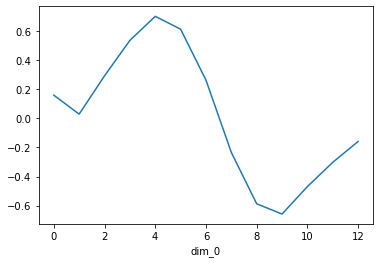

In [47]:
for m in range(1,13):
     climo[m] = np.mean(nino[m::12])
        
climo.plot()

In [73]:
nino_anom = nino;

tmp1,tmp2 = xr.broadcast(climo[m],nino[m::12])
tmp1.shape

for m in range(0,12):
#     print(m)
    tmp1 = xr.broadcast(climo[m],nino[m::12])
#     tmp1.shape
#     nino[m::12].shape
    nino_anom[m::12] = nino[m::12]-tmp1
#     nino_anom[m::12] = nino[m::12]-climo[m]
    
# #     nino_anom[m::12] = nino[m::12]-climo[m]

# nino_anom.plot()

ValueError: shape mismatch: value array of shape (50, 1) could not be broadcast to indexing result with 1 dimensions

In [70]:
nino[m::12].shape

(50,)

### Subset data to Nino region
#### I assume there's a more elegant way to do this, please insert if you know one

In [29]:
nino = ds.where((minlon < ds.lon) & (ds.lon < maxlon) & (minlat < ds.lat) & (ds.lat < maxlat), drop=True)

#### Also subset latitudes and longitudes

In [30]:
lats = ds.lat.where((minlat < ds.lat) & (ds.lat < maxlat), drop=True)
lons = ds.lon.where((minlon < ds.lon) & (ds.lon < maxlon), drop=True)

### Check if subsetting worked

In [31]:
ds.shape

(600, 192, 288)

In [32]:
nino.shape

(600, 10, 39)

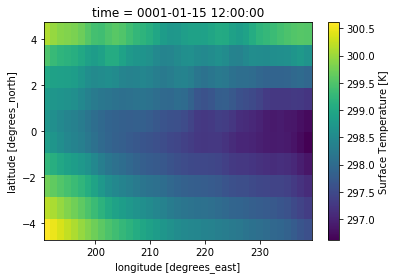

In [33]:
nino[0,:,:].plot()

### Compute area-weighted average
#### First create weights

In [59]:
latsr = np.deg2rad(lats)
lat_weights = np.cos(latsr)

In [60]:
lat_weights.shape

(10,)

#### Again, there's likely an cleaner way using "broadcast", but I couldn't get it to produce the right format (time x lat x lon) right away

In [61]:
# weights = xr.broadcast(lat_weights,nino[0,:,:]) # <-- ignore

dims = nino.shape
# weights = np.transpose(np.matlib.repmat(lat_weights,dims[1],1))
# weights = np.tile(lat_weights,[dims[0],dims[2],1])

tmp1,tmp2 = xr.broadcast(lat_weights,nino,exclude=['lat'])
weights = tmp1.transpose('time','lat','lon')

#### Normalize weights

In [62]:
weights = weights/np.sum(np.sum(weights,axis=1),axis=1)

#### Multiply data with weights and sum up to obtain time series

TypeError: 'module' object is not callable

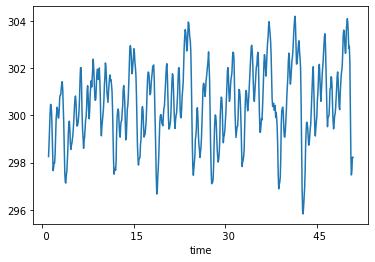

In [65]:
ts = np.sum(np.sum((nino*weights),axis=1),axis=1)
ts.plot()

#### Compute DJF means

In [31]:
ts_DJF = ts.where(ts['time.season'] == 'DJF')
ts_DJF = ts_DJF.rolling(min_periods=3, center=True, time=3).mean()
ts_DJF = ts_DJF.groupby('time.year').mean('time')
# ts.plot()
# ts_DJF.plot()
# plt.show()
ts_DJF
ts

/ncar/usr/jupyterhub/envs/cmip6-201910a/lib/python3.7/site-packages/xarray/core/nanops.py:140: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


<xarray.DataArray (time: 600)>
array([298.25777809, 298.77277499, 299.45689579, 300.02997271,
       300.46643681, 300.44929018, 300.13428371, 299.39361003,
       298.46984437, 297.66094837, 297.79303889, 297.99147473,
       297.98404209, 298.37884478, 299.13985417, 299.86300022,
       300.13417336, 300.34779602, 300.2264993 , 299.90242519,
       299.8878055 , 300.22498787, 300.75030665, 300.86787286,
       300.87549093, 301.14163515, 301.31804442, 301.43046147,
       301.08456468, 300.43725654, 299.65181962, 298.61958148,
       297.58322285, 297.17382956, 297.13514972, 297.48972908,
       297.62760476, 298.03455747, 298.52650474, 299.21825817,
       299.6530549 , 299.75743018, 299.4147717 , 298.82003745,
       298.56026174, 298.73478058, 298.81964278, 298.99177541,
       299.19880448, 299.50618395, 299.86698631, 300.35108387,
       300.67821508, 300.8226552 , 300.59591636, 299.96645332,
       299.54814419, 299.57435868, 299.67411142, 299.88404056,
       300.19526934, 300